In [ ]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r3d_18, R3D_18_Weights
import torch.nn as nn

# Force use of CPU only:
device = torch.device("cpu")
print("✅ Using device:", device)


✅ Using device: cpu


In [3]:
class VideoDataset(Dataset):
    def __init__(self, video_dir, clip_len=16, transform=None):
        self.video_paths = []
        self.labels = []
        self.clip_len = clip_len
        self.transform = transform

        # Collect folders as classes
        class_folders = sorted([
            d for d in os.listdir(video_dir)
            if os.path.isdir(os.path.join(video_dir, d))
        ])
        self.class_to_idx = {cls: i for i, cls in enumerate(class_folders)}
        self.classes = class_folders
        print("Classes found:", self.classes)
        print("Class->idx map:", self.class_to_idx)

        # Gather video paths and labels
        for cls in class_folders:
            class_path = os.path.join(video_dir, cls)
            for file in os.listdir(class_path):
                if file.endswith('.mp4'):
                    self.video_paths.append(os.path.join(class_path, file))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(path)

        frames = []
        while len(frames) < self.clip_len:
            ret, frame = cap.read()
            if not ret:
                break
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(img_rgb)
            if self.transform:
                tensor = self.transform(pil_img)
                frames.append(tensor)

        cap.release()

        # Pad if not enough frames
        if len(frames) < self.clip_len:
            for _ in range(self.clip_len - len(frames)):
                frames.append(frames[-1])

        # Shape: (channels=3, time=clip_len, height, width)
        clip = torch.stack(frames[:self.clip_len], dim=1)
        return clip, label


In [4]:
# Transform definition
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.43216, 0.394666, 0.37645],
                         [0.22803, 0.22145, 0.216989]),
])

# Build your dataset
data_dir = "dataset/videos"
dataset = VideoDataset(data_dir, clip_len=16, transform=transform)

if len(dataset) == 0:
    raise ValueError("❌ Dataset is empty. Please check the dataset path/folders.")

# Split train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
if train_size == 0 or val_size == 0:
    raise ValueError("❌ Not enough data to split into train and val sets.")

train_ds, val_ds = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

# Check labels
classes = dataset.classes
unique_labels = sorted(set(label for _, label in train_ds))
print("✅ Unique labels in training set:", unique_labels)

# Must match range [0..len(classes)-1]
for label in unique_labels:
    if label < 0 or label >= len(classes):
        raise ValueError(
            f"Label {label} is out of range! Valid range: [0..{len(classes)-1}]"
        )


Classes found: ['bench press', 'deadlift', 'squat']
Class->idx map: {'bench press': 0, 'deadlift': 1, 'squat': 2}
✅ Unique labels in training set: [0, 1, 2]


In [5]:
# Build model (on CPU)
model = r3d_18(weights=R3D_18_Weights.KINETICS400_V1)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)  # keep on CPU
print("✅ Model on device:", next(model.parameters()).device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


✅ Model on device: cpu


In [7]:
num_epochs = 10

# (Optional) to store metrics for plotting later:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    ############################################################################
    # 1) Training Pass
    ############################################################################
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        running_train_loss += loss.item()
        
        # Compute accuracy for this batch
        _, preds = torch.max(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Average train loss across the entire training set
    train_loss = running_train_loss / len(train_loader)
    # Accuracy = correct / total
    train_acc = correct_train / total_train

    ############################################################################
    # 2) Validation Pass
    ############################################################################
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            # Compute accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    # Average val loss across the entire validation set
    val_loss = running_val_loss / len(val_loader)
    # Validation accuracy
    val_acc = correct_val / total_val

    ############################################################################
    # 3) Print & Store Metrics
    ############################################################################
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/10] Train Loss: 0.5096 | Train Acc: 0.8478 Val Loss: 0.1408 | Val Acc: 0.9583
Epoch [2/10] Train Loss: 0.5066 | Train Acc: 0.8043 Val Loss: 0.1345 | Val Acc: 0.9583
Epoch [3/10] Train Loss: 0.3850 | Train Acc: 0.8587 Val Loss: 0.0765 | Val Acc: 1.0000
Epoch [4/10] Train Loss: 0.3017 | Train Acc: 0.9130 Val Loss: 0.0923 | Val Acc: 0.9583
Epoch [5/10] Train Loss: 0.5003 | Train Acc: 0.8587 Val Loss: 0.0548 | Val Acc: 1.0000
Epoch [6/10] Train Loss: 0.2836 | Train Acc: 0.9348 Val Loss: 0.1042 | Val Acc: 0.9583
Epoch [7/10] Train Loss: 0.2465 | Train Acc: 0.9457 Val Loss: 0.0400 | Val Acc: 1.0000
Epoch [8/10] Train Loss: 0.2310 | Train Acc: 0.9565 Val Loss: 0.1641 | Val Acc: 0.9583
Epoch [9/10] Train Loss: 0.2548 | Train Acc: 0.9457 Val Loss: 0.0659 | Val Acc: 1.0000
Epoch [10/10] Train Loss: 0.2244 | Train Acc: 0.9348 Val Loss: 0.0998 | Val Acc: 1.0000


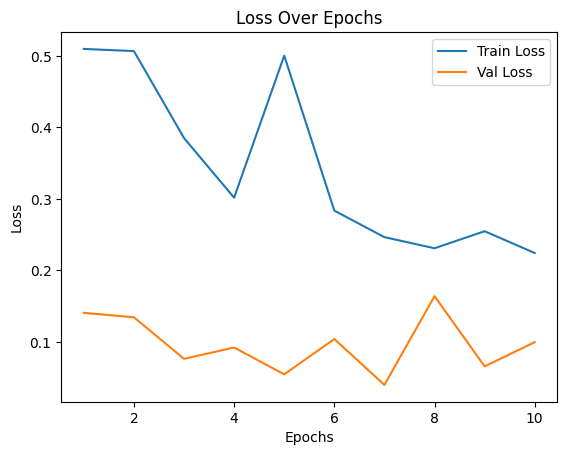

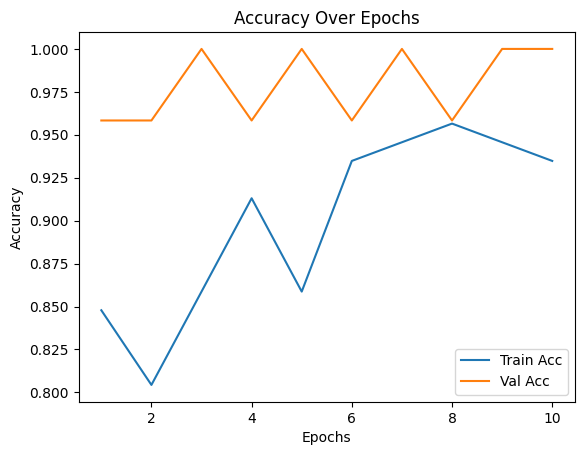

In [8]:
import matplotlib.pyplot as plt

# Suppose you have the following lists:
# num_epochs, train_loss_list, val_loss_list, train_acc_list, val_acc_list

# 1) Plot Loss Over Epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss_list, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

# 2) Plot Accuracy Over Epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Acc")
plt.plot(range(1, num_epochs + 1), val_acc_list, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


In [9]:
import os

# Make sure the directory exists (creates it if needed)
os.makedirs("models", exist_ok=True)

# Save the state_dict of your trained model
save_path = "models/model_r3d18_3cat_wweights.pth"
torch.save(model.state_dict(), save_path)

print(f"💾 Model saved to {save_path}")


💾 Model saved to models/model_r3d18_3cat_wweights.pth
